# Capstone
## The Battle of the Neighborhoods
### Chinese restaurants in NYC
_Yichun Hu_

#### Introduction

The number of Chinese immigrants in NYC has risen sharply in recent years — with Chinese people only trailing Dominicans as the largest foreign-born population in NYC. People of Chinese descent have spread farther out in larger numbers and developed communities along the way that at this point can be considered mini Chinatowns(Eater,2019). Along with the spurt of Chinese immigrant, the need to enjoy Chinese cuisine is on the rise. This final project explores the best locations for Chinese resturants throughout the city of New York.

#### Problem Statement
1)Where should I go to have the best Italian food in New York?
2)What is the best locations for Chinese cuisine?
3)Where can you find the most chinese food in New York?

#### Data

In order to explore  the above questions, data on New York City neighborhoods, boroughs to include boundaries, latitude, longitude, restaurants, and restaurant ratings and tips are required.

New York City data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cocl.us/new_york_dataset

New York City data containing neighborhood boundaries will be obtained from the data source: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

All data related to locations and quality of Italian restaurants will be obtained via the FourSquare API utilized via the Request library in Python.



#### Methodology

• Data will be collected from https://cocl.us/new_york_dataset and cleaned and processed into a dataframe.

• FourSquare will be used to locate all venues and then filtered by Italian restaurants. Ratings, tips, and likes by users will be counted and added to the dataframe.

• Data will be sorted based on rankings

• Finally, the data be will be visually assessed using graphing from various Python libraries.

Load Libararies

In [1]:
! python -m pip install folium

     |████████████████████████████████| 93 kB 1.3 MB/s eta 0:00:011


In [2]:
import pandas as pd
import numpy as np
import requests
#from bs4 import BeautifulSoup
import os
#!conda install -c conda-forge folium=0.5.0 --yes
import folium #import folium # map rendering library

In [4]:
! python -m pip install geopy

     |████████████████████████████████| 113 kB 3.2 MB/s eta 0:00:01


In [5]:


#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

print('Done!')

Done!


In [25]:
CLIENT_ID = 'BXNA5P5E1UPHVQER4J0G5VJFP1UE4CHL5I1VIAVXVZ0H54U2' # your Foursquare ID
CLIENT_SECRET = 'S1LEMRSGVSRE5L2H4JZQGITZYYXTABSANDAYR0432LDXBOEF' # your Foursquare Secret
VERSION = '20200522'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: BXNA5P5E1UPHVQER4J0G5VJFP1UE4CHL5I1VIAVXVZ0H54U2
CLIENT_SECRET:S1LEMRSGVSRE5L2H4JZQGITZYYXTABSANDAYR0432LDXBOEF


In [9]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [10]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [12]:
ny_data.shape

(306, 4)

After we get the New York Data, lets look deeper into the data.
-How many buroughs are there in NYC?
-How many neighborhoods are there in each burough?
-Which berough has the least number of neighborhoods among all the buroughs?

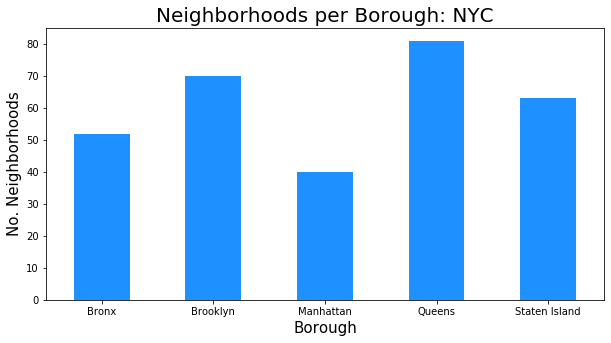

In [13]:
clr = "dodgerblue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

In the above graph, we now know that there are 5 buroughs in NYC and Manhattans has the least amount of Neighborhoods.

After analyzing the data, lets look further at how many chinese restuarants are there in each neighnorhood and burough. To do this, we graph the result in the bar charts.

In [14]:
ny_data.values.tolist()

[['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902],
 ['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398],
 ['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412],
 ['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682],
 ['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857],
 ['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604],
 ['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981],
 ['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176],
 ['Bronx', 'Norwood', 40.87722415599446, -73.8793907395681],
 ['Bronx', 'Williamsbridge', 40.88103887819211, -73.85744642974207],
 ['Bronx', 'Baychester', 40.866858107252696, -73.83579759808117],
 ['Bronx', 'Pelham Parkway', 40.85741349808865, -73.85475564017999],
 ['Bronx', 'City Island', 40.84724670491813, -73.78648845267413],
 ['Bronx', 'Bedford Park', 40.870185164975325, -73.8855121841913],
 ['Bronx', 'University Heights', 40.85572707719664, -73.9104159619131],
 ['Bronx',

In [16]:
# queens has most neighborhoods
# prepare neighborhood list that contains Chinese resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
chinese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    chinese_resturants=venues[venues['Category']=='Chinese Restaurant']   
    print('(',count,'/',len(ny_data),')','Chinese Resturants in '+Neighborhood+', '+Borough+':'+str(len(chinese_resturants)))
    print(row)
    for resturant_detail in chinese_resturants.values.tolist():
        id, name , category=resturant_detail
        chinese_rest_ny = chinese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Chinese Resturants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Chinese Resturants in Co-op City, Bronx:1
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Chinese Resturants in Eastchester, Bronx:1
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Chinese Resturants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Chinese Resturants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Chinese Resturants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Chinese Resturants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Chinese Resturants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Chinese Resturants in Norwood, Bronx:0
['Bronx', '

In [17]:
chinese_rest_ny.to_csv(r'C:\Users\YichunHu\Desktop\chinese_rest_ny.csv') # Save the information so far to a .csv file due to limited calls on FourSquare

In [18]:
chinese_rest_ny = pd.read_csv(r'C:\Users\YichunHu\Desktop\chinese_rest_ny.csv')
chinese_rest_ny.tail()

,Unnamed: 0,Borough,Neighborhood,ID,Name
177,177,Brooklyn,Homecrest,4d064e228620224b0490b240,Kowloon Island
178,178,Bronx,Allerton,4c7dbf7f10916dcba78e2a96,Chef King
179,179,Bronx,Kingsbridge Heights,4d965fd061a3a1cde4989a42,Lucky Star Chinese Restaurant
180,180,Bronx,Kingsbridge Heights,4c7851e03badb1f7137c4b54,Yu Hua Restaurant
181,181,Brooklyn,Erasmus,4e10c87122713f7d7bcb9d1d,Kam Man Chinese Food


In [19]:
chinese_rest_ny.shape

(182, 5)

After we create a table that extracts the chinese resturants data which we need, lets see how mant Chinese resturants per borough in NYC.

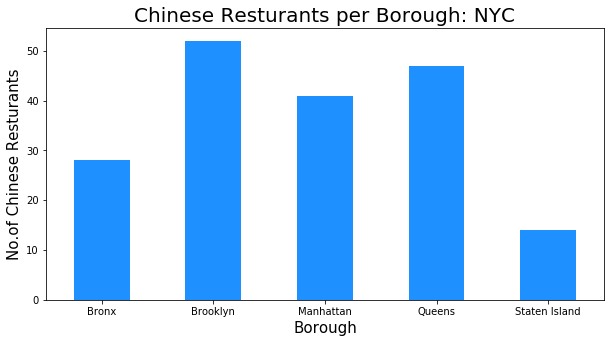

In [20]:
#group by Borough, count the number of ID and then plot the graph in bar chart
chinese_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color = clr)
plt.title('Chinese Resturants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Chinese Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

Brooklyn has the highest number of Chinese restaurants

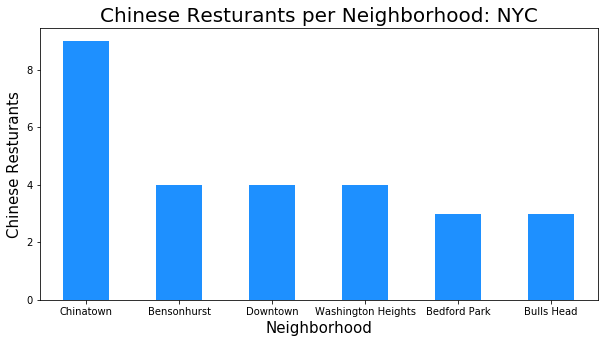

In [21]:
NOofNeigh = 6 # top number for graphing all the same past 6
chinese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Chinese Resturants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Chinese Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [22]:
CLIENT_ID = 'ZSIABOTQKJM4B4M4501DJNT54BUHQS2WY1TB3QNJ1EDK0VKW' # your Foursquare ID
CLIENT_SECRET = 'M4ESIQHKBDT1XU3CVO5UABG0DSPHXK1434TXK30PAHJFUXBI' # your Foursquare Secret
VERSION = '20200522'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
#due to limited calls

Your credentails:
CLIENT_ID: ZSIABOTQKJM4B4M4501DJNT54BUHQS2WY1TB3QNJ1EDK0VKW
CLIENT_SECRET:M4ESIQHKBDT1XU3CVO5UABG0DSPHXK1434TXK30PAHJFUXBI


In [23]:
chinese_rest_ny.values.tolist()

[[0,
  'Bronx',
  'Co-op City',
  '4c9d5f2654c8a1cd2e71834b',
  'Guang Hui Chinese Restaurant'],
 [1,
  'Bronx',
  'Eastchester',
  '4dabc3dc93a04642f09ccabd',
  'Xing Lung Chinese Restaurant'],
 [2,
  'Bronx',
  'Pelham Parkway',
  '4b9d6b45f964a52078ab36e3',
  "Mr. Q's Chinese Restaurant"],
 [3,
  'Bronx',
  'Pelham Parkway',
  '4bc8f646b6c49c74d8898d91',
  'Great Wall Chinese Restaurant'],
 [4,
  'Bronx',
  'Bedford Park',
  '4e4d0387bd413c4cc66dfd72',
  'Hung Hing Chinese Restaurant'],
 [5,
  'Bronx',
  'Bedford Park',
  '4c87c9930dcb8cfa68e63d68',
  'New Xing Wang Chinese Restaurant'],
 [6,
  'Bronx',
  'Bedford Park',
  '4d081644e554721e5423c0f8',
  'Wai Kang Kitchen Chinese Food'],
 [7,
  'Bronx',
  'East Tremont',
  '4ccf58277f56a1434cfec6a6',
  'Wings Chinese Restaurant'],
 [8, 'Bronx', 'West Farms', '4cd0d4d77b6854810401c4f8', 'Food Hai'],
 [9,
  'Bronx',
  'Soundview',
  '4cc63e36bde8f04dcbfeb54b',
  'Golden City Chinese Restaurant'],
 [10, 'Bronx', 'Soundview', '4e656e8252b

In [26]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
chinese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in chinese_rest_ny.values.tolist():
    Number,Borough,Neighborhood,ID,Name = row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(chinese_rest_ny),')','processed')
    chinese_rest_stats_ny = chinese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
chinese_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '5ece2db0bae9a2001b6b1995'}, 'response': {'venue': {'id': '4c9d5f2654c8a1cd2e71834b', 'name': 'Guang Hui Chinese Restaurant', 'contact': {'phone': '7188623288', 'formattedPhone': '(718) 862-3288'}, 'location': {'address': '125 Dreiser Loop', 'lat': 40.876651, 'lng': -73.829092, 'labeledLatLngs': [{'label': 'display', 'lat': 40.876651, 'lng': -73.829092}, {'label': 'entrance', 'lat': 40.876084, 'lng': -73.829209}], 'postalCode': '10475', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['125 Dreiser Loop', 'Bronx, NY 10475', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/guang-hui-chinese-restaurant/4c9d5f2654c8a1cd2e71834b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'st

KeyError: 'venue'

In [27]:
chinese_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Co-op City,0,0,0,0,0
1,Bronx,Eastchester,0,0,0,0,0
2,Bronx,Pelham Parkway,4b9d6b45f964a52078ab36e3,Mr. Q's Chinese Restaurant,9,7.2,10
3,Bronx,Pelham Parkway,0,0,0,0,0
4,Bronx,Bedford Park,4e4d0387bd413c4cc66dfd72,Hung Hing Chinese Restaurant,5,6,2


In [28]:
chinese_rest_stats_ny.to_csv(r'C:\Users\YichunHu\Desktop\chinese_rest_stats_ny.csv') # I continue to save data to a .csv as I move through this project

In [29]:
chinese_rest_stats_ny = pd.read_csv(r'C:\Users\YichunHu\Desktop\chinese_rest_stats_ny.csv')


In [30]:
chinese_rest_stats_ny.describe()

,Unnamed: 0,Likes,Rating,Tips
count,50.00000,50.000000,50.000000,50.000000
mean,24.50000,12.860000,2.746000,6.320000
std,14.57738,34.177215,3.459811,14.506072
min,0.00000,0.000000,0.000000,0.000000
25%,12.25000,0.000000,0.000000,0.000000
50%,24.50000,0.000000,0.000000,0.000000
75%,36.75000,5.000000,6.150000,4.000000
max,49.00000,161.000000,8.900000,77.000000


In [32]:
chinese_rest_stats_ny['Likes']=chinese_rest_stats_ny['Likes'].astype('float64')
chinese_rest_stats_ny['Tips']=chinese_rest_stats_ny['Tips'].astype('float64')
chinese_rest_stats_ny['Rating']=chinese_rest_stats_ny['Rating'].astype('float64')
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
Unnamed: 0      50 non-null int64
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null float64
Rating          50 non-null float64
Tips            50 non-null float64
dtypes: float64(3), int64(1), object(4)
memory usage: 3.2+ KB


In [33]:
# Resturant with maximum Likes
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Likes'].idxmax()]


Unnamed: 0                            46
Borough                         Brooklyn
Neighborhood                    Downtown
ID              59da9590e1f0aa52976b8f35
Name                         Han Dynasty
Likes                                161
Rating                               8.6
Tips                                  32
Name: 46, dtype: object

In [34]:
#Resturants with maximum ratings
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Rating'].idxmax()]


Unnamed: 0                            29
Borough                         Brooklyn
Neighborhood             Windsor Terrace
ID              54e39b14498e9c646b42958e
Name                East Wind Snack Shop
Likes                                138
Rating                               8.9
Tips                                  50
Name: 29, dtype: object

In [35]:
# Resturant with maximum Tips
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Tips'].idxmax()]

Unnamed: 0                            45
Borough                         Brooklyn
Neighborhood                Clinton Hill
ID              4a71ff01f964a52016da1fe3
Name                             Kum Kau
Likes                                110
Rating                               7.7
Tips                                  77
Name: 45, dtype: object

In [36]:
ny_neighborhood_stats=chinese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False)


,Neighborhood,Average Rating
8,Clinton Hill,7.700
14,Downtown,7.625
33,Windsor Terrace,7.450
1,Bay Ridge,7.200
25,Park Slope,7.200
19,Gowanus,6.600
21,Greenpoint,6.200
4,Brooklyn Heights,6.050
5,Bushwick,5.800
24,North Riverdale,5.800


In [37]:
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Bath Beach,0.000
1,Bay Ridge,7.200
2,Bedford Park,2.000
3,Bensonhurst,0.000
4,Brooklyn Heights,6.050
5,Bushwick,5.800
6,Canarsie,0.000
7,Carroll Gardens,5.600
8,Clinton Hill,7.700
9,Co-op City,0.000


In [38]:
ny_borough_stats=chinese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Brooklyn,3.460
0,Bronx,1.675


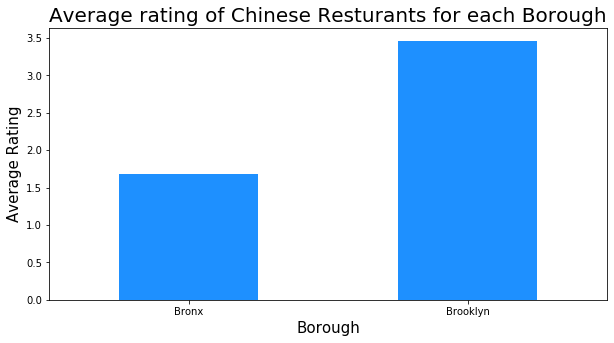

In [39]:
chinese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot.bar(figsize=(10,5), color=clr)
plt.title('Average rating of Chinese Resturants for each Borough', fontsize=20)
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [40]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating


In [41]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating


In [42]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()
# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [43]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

In [44]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = 'Borough Boundaries.geojson'
ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)
# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

/srv/conda/envs/notebook/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


FileNotFoundError: [Errno 2] No such file or directory: 'Borough Boundaries.geojson'

Finally, We will visualize all NYC buroughs based on average Rating.

In [45]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'Borough Boundaries.geojson'
ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='PuBu', #'YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)
# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

FileNotFoundError: [Errno 2] No such file or directory: 'Borough Boundaries.geojson'

## Results /Conclusion